In [ ]:
pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.compose import make_column_transformer

########### mflow ############
import mlflow
import mlflow.sklearn
########### mflow ############

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sharelib import *
import logging
from pathlib import Path
import json
import glob
import sys

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [3]:
if __name__ == "__main__":
    df = pd.DataFrame()
    path_to_json = 'rawdata3' 
    json_pattern = os.path.join(path_to_json,'*.txt')
    file_list = glob.glob(json_pattern)
    
    xcount = 0

    for file in file_list:
        xcount = xcount + 1
        print("xcount: ", xcount)
        data = pd.read_json(file, lines=True)
        df = pd.concat([df,data], ignore_index = True)

xcount:  1


In [4]:
    np.set_printoptions(threshold=sys.maxsize)
    
    df_categories = pd.concat([df["ads_country_dst"]], axis=1, sort=False,)
    X_label = df_categories.apply(LabelEncoder().fit_transform)
    df["ads_country_dst2"] = 0
    X = pd.concat([X_label,df["ads_country_dst2"]], axis=1, sort=False,)

In [5]:
# Call and fit the Local Outlier Factor detector
lof_detector = LocalOutlierFactor(n_neighbors=10, contamination=0.01,novelty=True).fit(X)
lof_detect = lof_detector.predict(X)
print(lof_detect)

C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

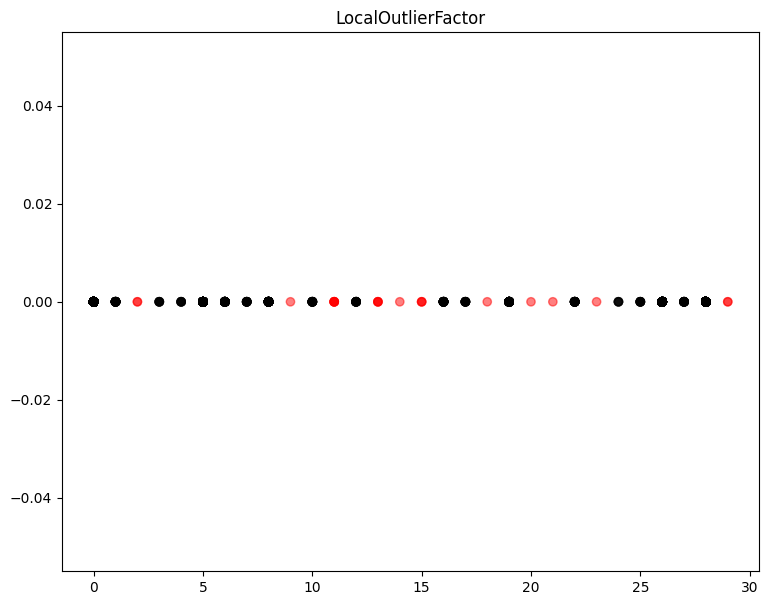

In [6]:
plt.figure(figsize=(9,7))
plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=lof_detect, cmap="flag", alpha=0.5)
plt.title("LocalOutlierFactor")
plt.show()

In [7]:
print(X[35:36 :])
print(lof_detector.predict(X))

    ads_country_dst  ads_country_dst2
35                5                 0


C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [9]:
%set_env MLFLOW_TRACKING_URI=http://127.0.0.1:5000
tracking_uri = os.environ["MLFLOW_TRACKING_URI"]
# export MLFLOW_TRACKING_USERNAME=user 
# export MLFLOW_TRACKING_PASSWORD=pwd

experiment = mlflow.get_experiment_by_name('soc-ml-LocalOutlierFactor')
experiment_id = experiment.experiment_id

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.set_tracking_uri(tracking_uri)
    
    print("Artifact Location: {}".format(experiment.artifact_location))
    print("artifact uri : " + mlflow.get_artifact_uri())

    mlflow.doctor()

    # mlflow.log_metric("score_trains", str(score_train))
    # mlflow.log_metric("score_test", str(score_test))
    mlflow.sklearn.log_model(lof_detector, "model", registered_model_name="soc-ml")
    print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

env: MLFLOW_TRACKING_URI=http://127.0.0.1:5000
Artifact Location: mlflow-artifacts:/394149324160139362
artifact uri : mlflow-artifacts:/394149324160139362/b3c6dfff0ec04041918996d7d10043b2/artifacts
System information: Windows 10.0.19045
Python version: 3.9.7
MLflow version: 2.1.1
MLflow module location: C:\Users\sutee.k\AppData\Roaming\Python\Python39\site-packages\mlflow\__init__.py
Tracking URI: http://127.0.0.1:5000
Registry URI: http://127.0.0.1:5000
Active experiment ID: 394149324160139362
Active run ID: b3c6dfff0ec04041918996d7d10043b2
Active run artifact URI: mlflow-artifacts:/394149324160139362/b3c6dfff0ec04041918996d7d10043b2/artifacts
MLflow environment variables: 
  MLFLOW_TRACKING_URI: http://127.0.0.1:5000
MLflow dependencies: 
  Flask: 2.3.3
  Jinja2: 3.1.2
  alembic: 1.12.0
  click: 8.1.7
  cloudpickle: 2.2.1
  databricks-cli: 0.17.8
  docker: 6.1.3
  entrypoints: 0.4
  gitpython: 3.1.37
  importlib-metadata: 5.2.0
  markdown: 3.4.4
  matplotlib: 3.8.0
  numpy: 1.25.2
  

Registered model 'soc-ml' already exists. Creating a new version of this model...
2023/10/01 23:19:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: soc-ml, version 18


Model saved in run b3c6dfff0ec04041918996d7d10043b2


Created version '18' of model 'soc-ml'.


In [10]:
!mlflow models serve -m mlflow-artifacts:/394149324160139362/b3c6dfff0ec04041918996d7d10043b2/artifacts/model -p 1234 --no-conda

^C
